# Denoising Diffusion Probabilistic Models (DDPM)

This notebook are my personal notes on the implementation of DDPM based on [Ho et al. (2020)](https://arxiv.org/abs/2006.11239#) and [Brian Pulfer Tutorial](https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1). The idea is to first apply a basic DDPM model to the MNIST data, then trying it out on the pokemon sprites dataset.

### Basic Idea

The basic idea is simple, given a set of images, we perturb each images through a Markov-Chain by adding a little bit of Gaussian Noise every timestep $t$ until Gaussian Noise is all that´s left. This process is called "forward diffusion" and follows the concept of non-equilibrium thermodynamics where the entropy is increased iteratively by adding noise. Now to revert this process, we learn a ML model (a DL model) to reverse this process to obtain high quality images back from noise iteratively (backward or reverse process). This way, a ML model learns the important/desired features from the dataset and learns to reconstruct these features from plain (Gaussian) noise.

### The math behind it

TBD: when I feel like doing LaTeX

$\mathcal{N}(x_t;\sqrt{1 - \beta_{t}}x_{t-1}, \beta_{t}I)$ is read as "Gaussian $\mathcal{N}$ PDF parametrized by $\mu=\sqrt{1 - \beta_{t}}x_{t-1}$, $\sigma = \beta{t}I$ evaluated at image $x$ at timestep $t$. A diagonal Covariance Matrix $\sigma$ indicates independency between all pixels in $x$.

## DDPM Implementation

In [1]:
batch_size = 128


### Some Preprocessing and Preparations

In [2]:
import torch
import matplotlib.pyplot as plt
from numpy import moveaxis
import numpy as np

def show_images(images, title=""):
    """
    Convenience Method for displaying several images in a grid
    """

    # Convert to numpy from tensor
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Decide size of grid
    fig = plt.figure(figsize=(8,8))
    rows = int(len(images) ** (1/2))
    cols = round(len(images) / rows)

    # construct subplots
    i = 0
    for _ in range(rows):
        for _ in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            ax.axis('off')
            if i < len(images):
                #print(f"Max: {images[i].max()}, Min: {images[i].min()}")
                img = (images[i] - images[i].min())/np.ptp(images[i])
                plt.imshow(moveaxis(img, 0, 2))
                i += 1
    fig.suptitle(title)

    plt.axis('off')
    plt.show()

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms
import os

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
# Init DataLoader from MNIST Dataset
mnist_ds = MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Lambda(lambda x: (x - 0.5) * 2),  #scale images to [-1:1]
                           ]))
mnist_loader = torch.utils.data.DataLoader(mnist_ds, batch_size=batch_size, shuffle=True, num_workers=0)


import torchvision.datasets as dset
import torchvision.transforms as transforms

# Root directory for dataset
dataroot = "data/pokemon_all"

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(), # converste images into [0,1.0]
                           ]))
# Create the dataloader
pokemon_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

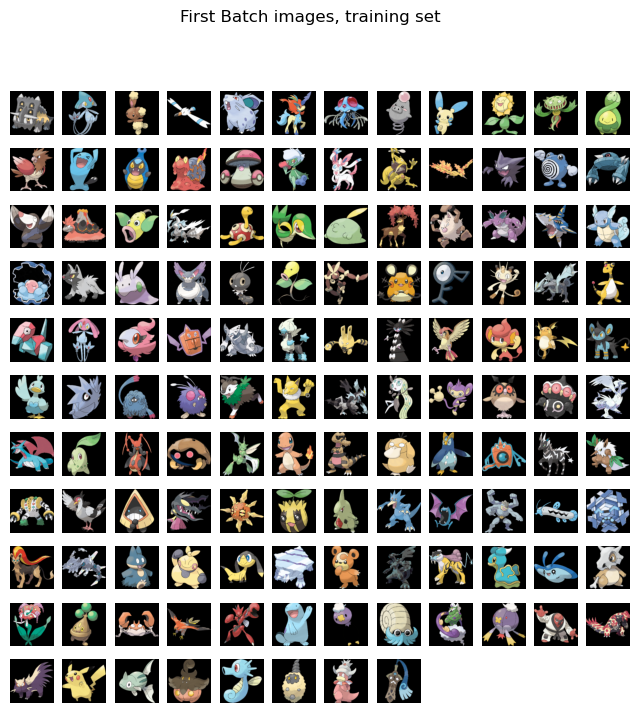

Using Device: cuda, 	NVIDIA GeForce RTX 3070 Ti


In [4]:
dataloader = pokemon_dataloader

# show first images
for batch in dataloader:
    show_images(batch[0], "First Batch images, training set")
    break

# show device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}, \t" +  f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU")

### The DDPM Model

### DDPM Noise Adding Module

In [5]:
import torch.nn as nn

class MyDDPM(nn.Module):
    """
    Module to add noise to a given image
    Not trainable network with weights!
    """

    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(MyDDPM, self).__init__()
        # number of steps T
        self.n_steps = n_steps
        # training device
        self.device = device
        # NN to reverse added noise
        self.network = network.to(device)
        # beta for controlling noise scale
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas

        # factor to control scale and mu of gaussian
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        """
        Forward pass (add noise) from x0 to t
        eta : noise scale, scaled by alpha for more/less noise added
        """
        assert max(t) < self.n_steps, "t bigger than T"

        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            # normally distributed noise vector
            eta = torch.randn(n, c, h, w).to(self.device)

        # sampling trick, by adding scaled noise to mean vector
        mean_vector = a_bar.sqrt().reshape(n, 1, 1, 1) * x0
        scaled_noise = (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta 
        # result noisy image
        noisy =  mean_vector + scaled_noise
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

### Denoising U-Net Model

In [6]:
class UNetBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(UNetBlock, self).__init__()
        # Layer Normalization ("vertical mean/sigma") : in contrast batch norm ("horizontal mean/sigma")
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        # Sigmoid Linear Unit
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [7]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding



In [8]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100, color_channels=1, img_size = 28):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            UNetBlock((color_channels, img_size, img_size), color_channels, 10),
            UNetBlock((10, img_size, img_size), 10, 10),
            UNetBlock((10, img_size, img_size), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        img_sizeb2 = img_size//2
        self.b2 = nn.Sequential(
            UNetBlock((10, img_sizeb2, img_sizeb2), 10, 20),
            UNetBlock((20, img_sizeb2, img_sizeb2), 20, 20),
            UNetBlock((20, img_sizeb2, img_sizeb2), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        img_sizeb3 = img_sizeb2 // 2
        self.b3 = nn.Sequential(
            UNetBlock((20, img_sizeb3, img_sizeb3), 20, 40),
            UNetBlock((40, img_sizeb3, img_sizeb3), 40, 40),
            UNetBlock((40, img_sizeb3, img_sizeb3), 40, 40)
        )
        self.down3 = nn.Sequential(
            #nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        img_sizeb_mid = img_sizeb3 // 2
        self.b_mid = nn.Sequential(
            UNetBlock((40, img_sizeb_mid, img_sizeb_mid), 40, 20),
            UNetBlock((20, img_sizeb_mid, img_sizeb_mid), 20, 20),
            UNetBlock((20, img_sizeb_mid, img_sizeb_mid), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            #nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            UNetBlock((80, img_sizeb3, img_sizeb3), 80, 40),
            UNetBlock((40, img_sizeb3, img_sizeb3), 40, 20),
            UNetBlock((20, img_sizeb3, img_sizeb3), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            UNetBlock((40, img_sizeb2, img_sizeb2), 40, 20),
            UNetBlock((20, img_sizeb2, img_sizeb2), 20, 10),
            UNetBlock((10, img_sizeb2, img_sizeb2), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            UNetBlock((20, img_size, img_size), 20, 10),
            UNetBlock((10, img_size, img_size), 10, 10),
            UNetBlock((10, img_size, img_size), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, color_channels, 3, 1, 1)

    def forward(self, x, t):
        """
        t: time tensor with dim (n_samples, t)?
        """
        
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        #print(x.size())
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        #print(out1.size())
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        #print(out2.size())
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)
        #print(out3.size())
        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)
        #print(out_mid.size())
        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        #print(out4.size())
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)
        #print(out5.size())
        
        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)
        #print(out.size())

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

### Training

In [9]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
n_channel = 3
ddpm = MyDDPM(MyUNet(n_steps, color_channels=n_channel, img_size=image_size), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)


In [10]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

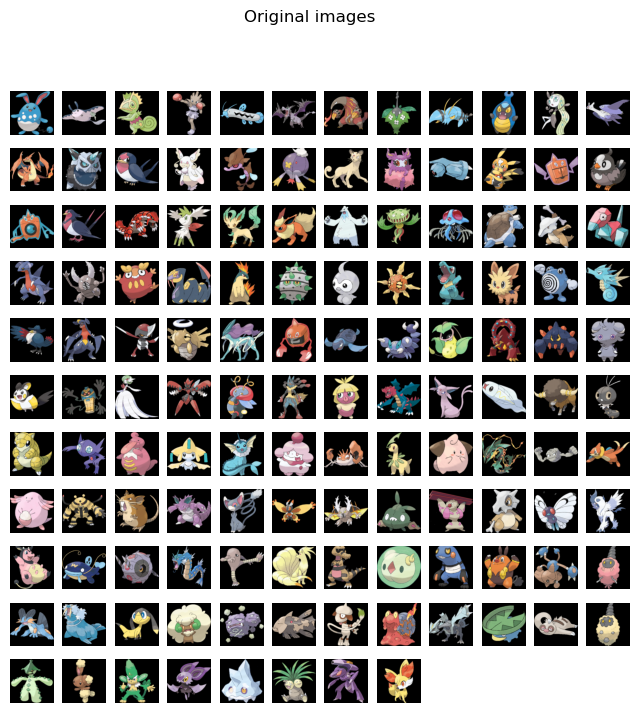

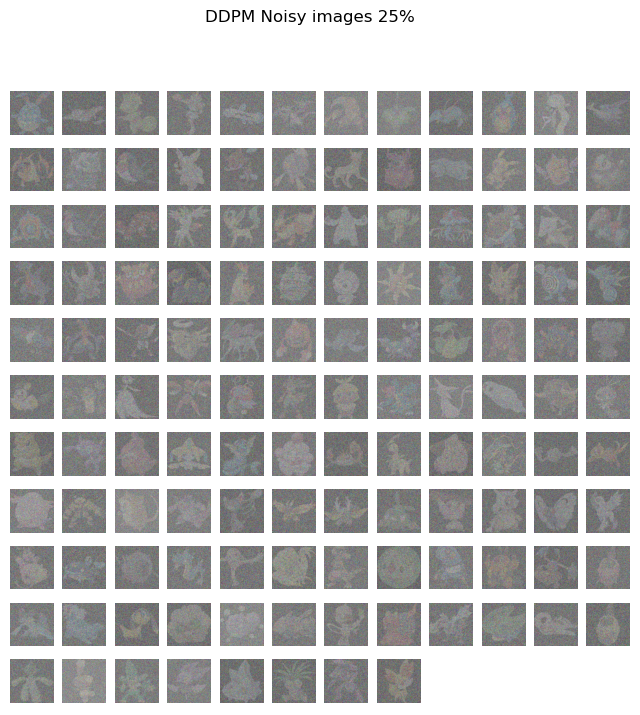

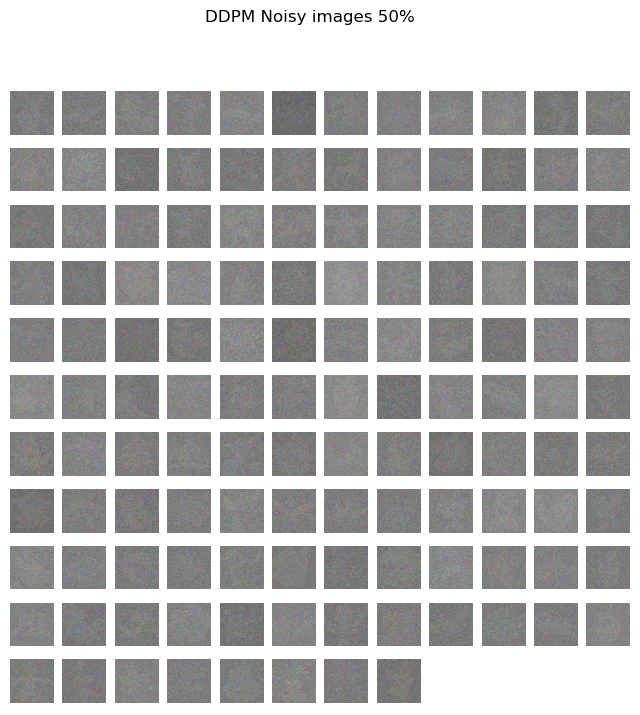

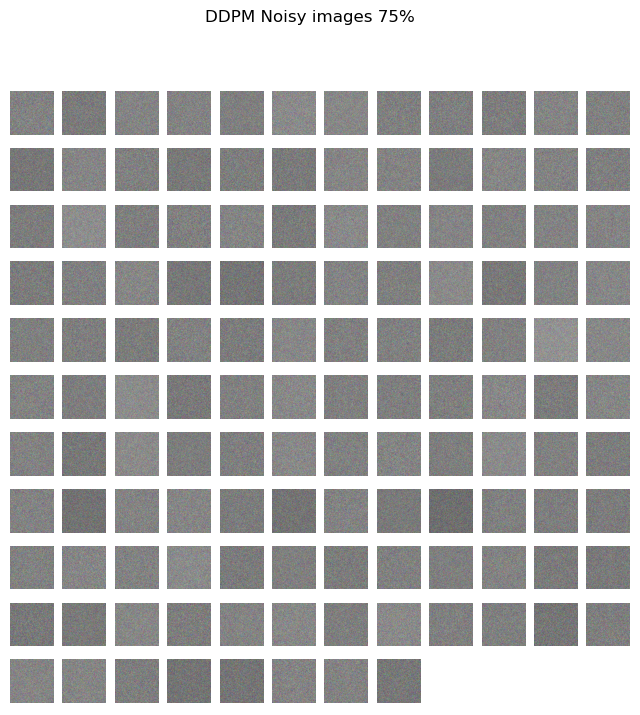

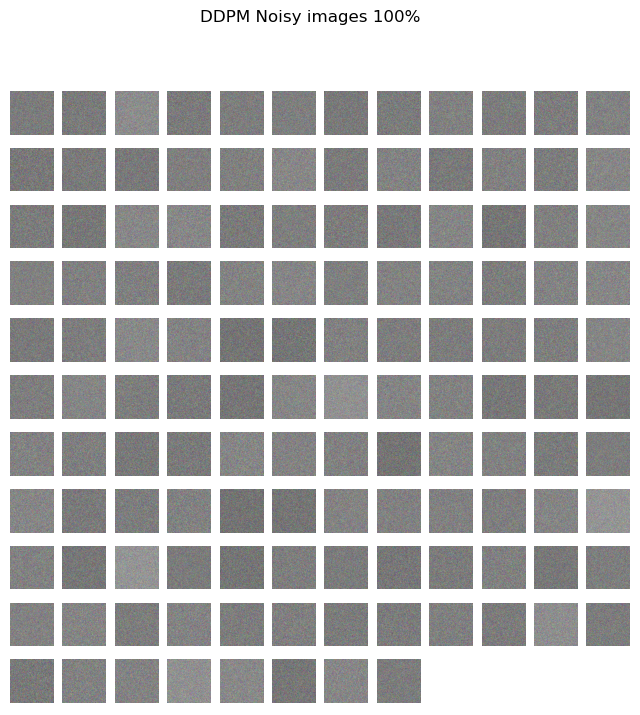

In [11]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, dataloader, device)

In [12]:
import imageio
import numpy as np 
import einops

def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)
        
        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)
            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

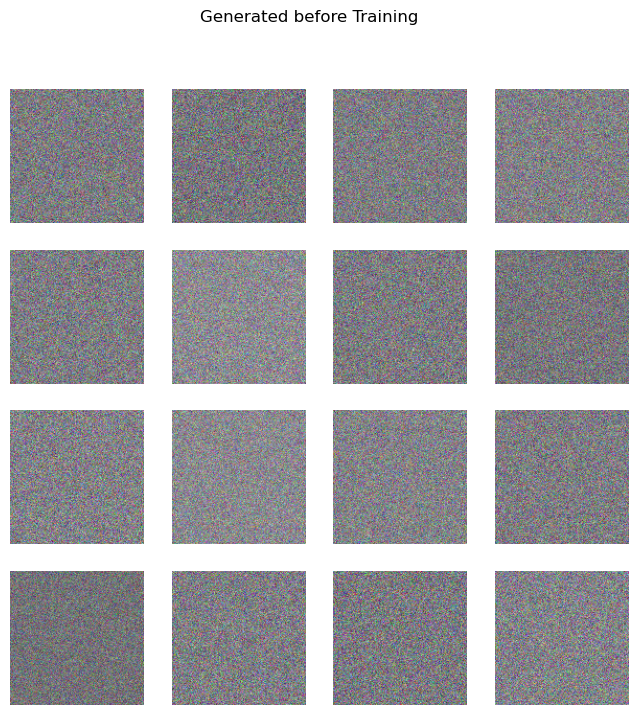

In [13]:
generated = generate_new_images(ddpm, gif_name="before_training.gif", c=n_channel, h=image_size, w=image_size)
show_images(generated, "Generated before Training")

In [14]:
from tqdm.auto import tqdm

def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for step, batch in enumerate(loader):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            #print(f"x0: {x0.size()}, eta: {eta.size()}")
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            #print(f"eta_theta: {eta_theta.size()}, eta: {eta.size()}")

            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

            print(log_string)

In [15]:
from torch.optim import Adam

n_epochs = 1000
lr = 0.001
store_path = "ddpm_pokemon.pt"
gif_name = "pokemon.gif"

training_loop(ddpm, pokemon_dataloader, n_epochs, Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Loss at epoch 1: 1.002 --> Best model ever (stored)
Loss at epoch 2: 0.987 --> Best model ever (stored)
Loss at epoch 3: 0.959 --> Best model ever (stored)
Loss at epoch 4: 0.913 --> Best model ever (stored)
Loss at epoch 5: 0.845 --> Best model ever (stored)
Loss at epoch 6: 0.793 --> Best model ever (stored)
Loss at epoch 7: 0.756 --> Best model ever (stored)
Loss at epoch 8: 0.728 --> Best model ever (stored)
Loss at epoch 9: 0.707 --> Best model ever (stored)
Loss at epoch 10: 0.687 --> Best model ever (stored)
Loss at epoch 11: 0.659 --> Best model ever (stored)
Loss at epoch 12: 0.630 --> Best model ever (stored)
Loss at epoch 13: 0.600 --> Best model ever (stored)
Loss at epoch 14: 0.571 --> Best model ever (stored)
Loss at epoch 15: 0.547 --> Best model ever (stored)
Loss at epoch 16: 0.511 --> Best model ever (stored)
Loss at epoch 17: 0.479 --> Best model ever (stored)
Loss at epoch 18: 0.448 --> Best model ever (stored)
Loss at epoch 19: 0.424 --> Best model ever (stored)
Lo

Model loaded
Set to evaluation mode
Generating new images


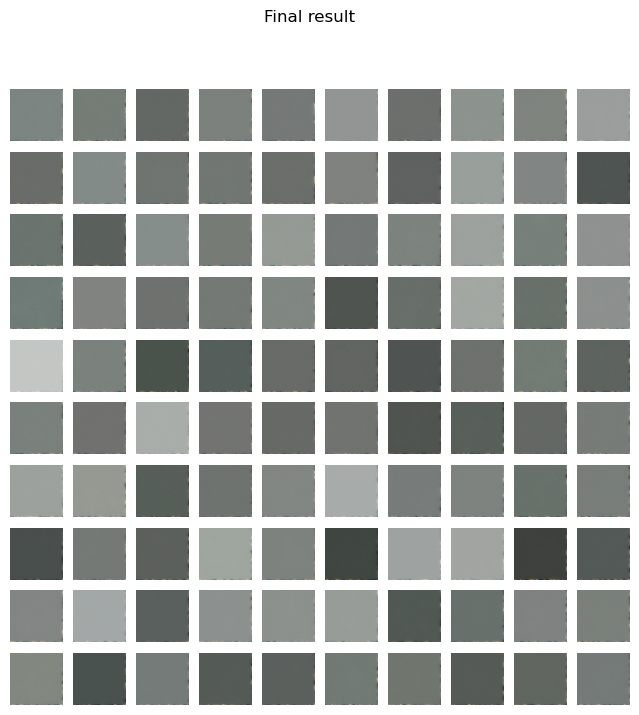

In [18]:
# Loading the trained model
best_model = MyDDPM(MyUNet(n_steps=n_steps, color_channels=n_channel, img_size=image_size), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
print("Model loaded")
best_model.eval()
print("Set to evaluation mode")

print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name=gif_name,
        c=3, h = image_size, w = image_size
    )
show_images(generated, "Final result")


# To Reasearch

### Why is t uniform?

### Standard Positional Embedding

#### Sinusoidal Embedding

#### Mapping (_make_te)

### U-Net

### Annealed Langevin Dynamics

